# STILL IN PROGRESS... estimated completion date: 04/20/2023

# BIKE SHARING DEMAND

__Data Fields__ <br>
__datetime__ - hourly date + timestamp <br>
__season__ -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br> 
__holiday__ - whether the day is considered a holiday <br>
__workingday__ - whether the day is neither a weekend nor holiday <br>
__weather__ - 1: Clear, Few clouds, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
__temp__ - temperature in Celsius <br>
__atemp__ - "feels like" temperature in Celsius <br>
__humidity__ - relative humidity <br>
__windspeed__ - wind speed <br>
__casual__ - number of non-registered user rentals initiated <br>
__registered__ - number of registered user rentals initiated <br>
__count__ - number of total rentals

In [1]:
# inporting useful librabries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mtl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

In [2]:
# setting custom color palettes http://colorbrewer2.org/

blue, ach = ['#4393c3'], ['#4d4d4d']
div1 = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']
div2 = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#e0e0e0','#bababa','#878787','#4d4d4d','#1a1a1a']
# sns.set_palette(a+b+div2+div1)

In [3]:
# loading train and test datasets

bikedf = pd.read_csv('./dataset/train.csv', sep=r',', parse_dates=['datetime'])
bikedf.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# accessing information about our train dataset

bikedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


### Dealing with datetime column
Converting the datetime columns into its components `[year, month, day, dayofweek, hour]`

In [5]:
def datetransform(df):
    """ Function Name: datetransform
            This function transforms (and replace) the datetime column of a dataframe
            into 5 separate components [year, month, day, dayofweek, hour].
    """
    
    dtime_df = pd.DataFrame()
    
    dtime_df['year'] = df['datetime'].dt.year
    dtime_df['month'] = df['datetime'].dt.month
    dtime_df['day'] = df['datetime'].dt.day # day on the calendar
    dtime_df['dayofweek'] = df['datetime'].dt.dayofweek
    dtime_df['hour'] = df['datetime'].dt.hour
    df.drop(columns='datetime', inplace=True)
    
    transformed_df = dtime_df.join(df)
    return transformed_df

In [6]:
# transforming datetime column in train and test datasets

bikedf = datetransform(bikedf)
bikedf.head()

,year,month,day,dayofweek,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,1,5,0,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011,1,1,5,1,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011,1,1,5,2,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011,1,1,5,3,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011,1,1,5,4,1,0,0,1,9.84,14.395,75,0.0,0,1,1


### DATA EXPLORATION AND PREPROCESSING

In [7]:
# making a copy of the train dataset (to maintain its integrity)
eda_df = bikedf.copy()

# Description of features
cols_description = ['hourly date and timestamp', 'Current Season', 'Day is holiday or not', 
                    'Day is working day or not', 'Current weather', 'Temperature in Celsius',
                    'Feels like temperature in Celsius', 'Relative humidity', 'Wind speed',
                    'Number of non-registered user rentals', 'Number of registed user rentals',
                    'Total number of rentals']

# continuous features
cont_cols = eda_df.columns.to_list()[9:-1] #['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']
print(f'Continuous Features: {cont_cols}')

# categorical features
cat_cols = eda_df.columns.to_list()[:9] #['year', 'month', 'day', 'dayofweek', 'hour', 'season', 'holiday', 'workingday', 'weather']
print(f'Categorical features: {cat_cols}')

# target features: casual, registered, count*
targets = eda_df.columns.to_list()[-3:]

Continuous Features: ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']
Categorical features: ['year', 'month', 'day', 'dayofweek', 'hour', 'season', 'holiday', 'workingday', 'weather']


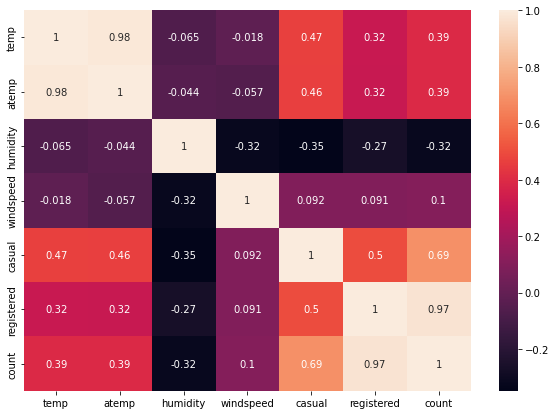

<Figure size 432x288 with 0 Axes>

In [8]:
# correlation between continuous features and count

numcols = cont_cols + ['count']
corr_mat = np.around(eda_df[numcols].corr(), 3)
plt.figure(figsize=(10,7))
sns.heatmap(corr_mat, annot=True)
plt.show() # interesting features: temp, humidity, casual*, registered*
plt.clf()

In [9]:
# # correlation between categorical features and count
# # *note to self* TRY USING CHI SQUARE INSTEAD

# catcols = cat_cols + ['count'] 
# corr_mat = np.around(eda_df[catcols].corr(), 3)
# plt.figure(figsize=(12,7))
# sns.heatmap(corr_mat, annot=True)
# plt.show() # interesting features: year, hour, season, weather
# plt.clf()

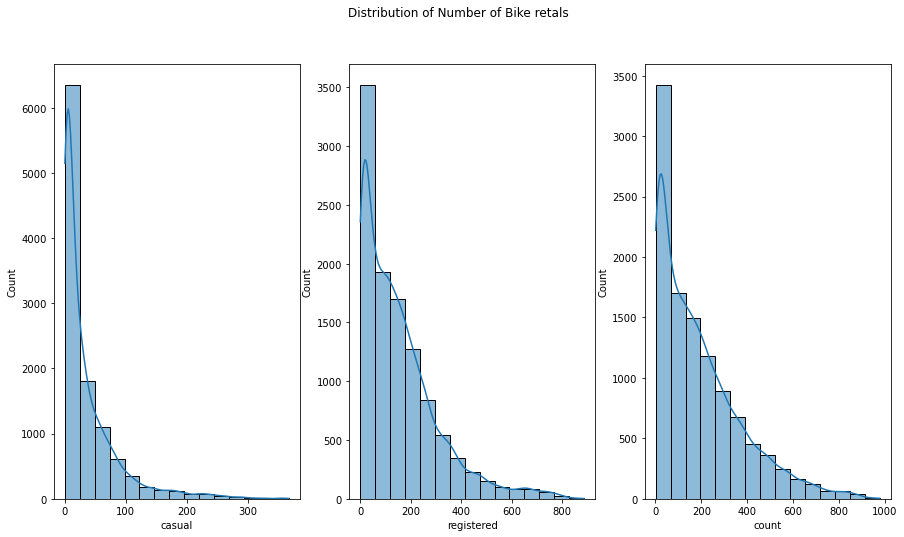

<Figure size 432x288 with 0 Axes>

In [10]:
# distribution of casual, registered, and count

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,8))
for i in range(3):
    sns.histplot(data=eda_df, bins=15, x=targets[i], ax=axs[i], kde=True)
fig.suptitle('Distribution of Number of Bike retals')
plt.show()
plt.clf()

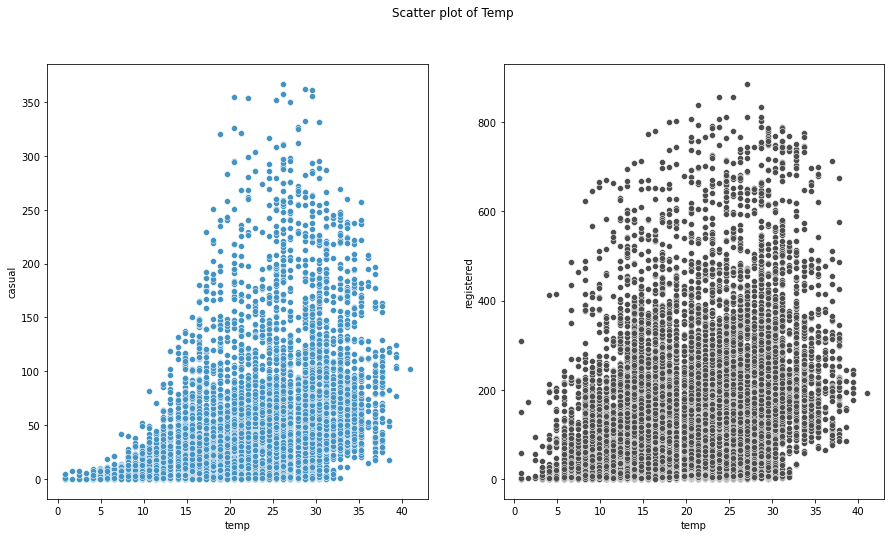

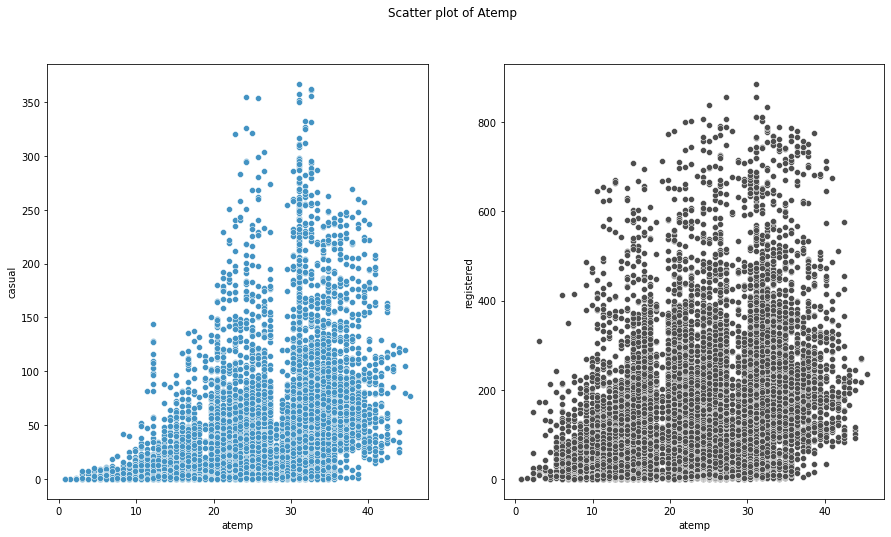

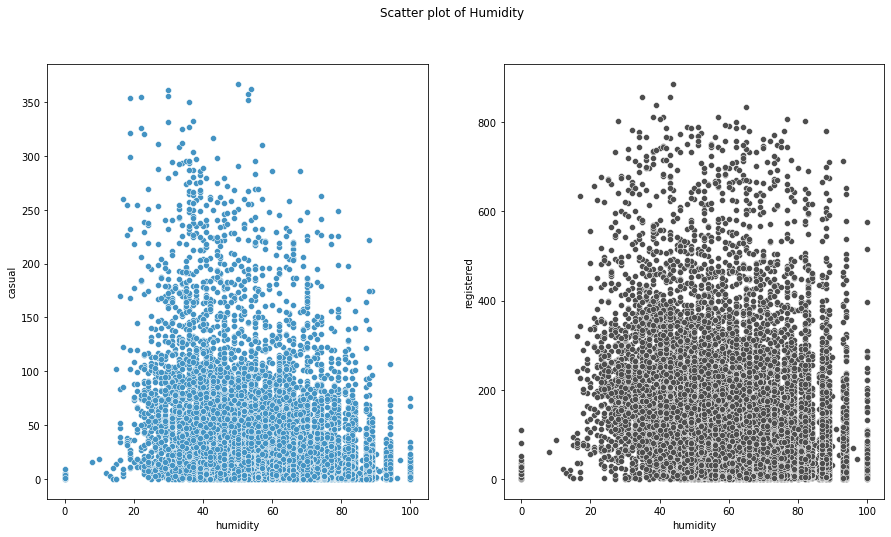

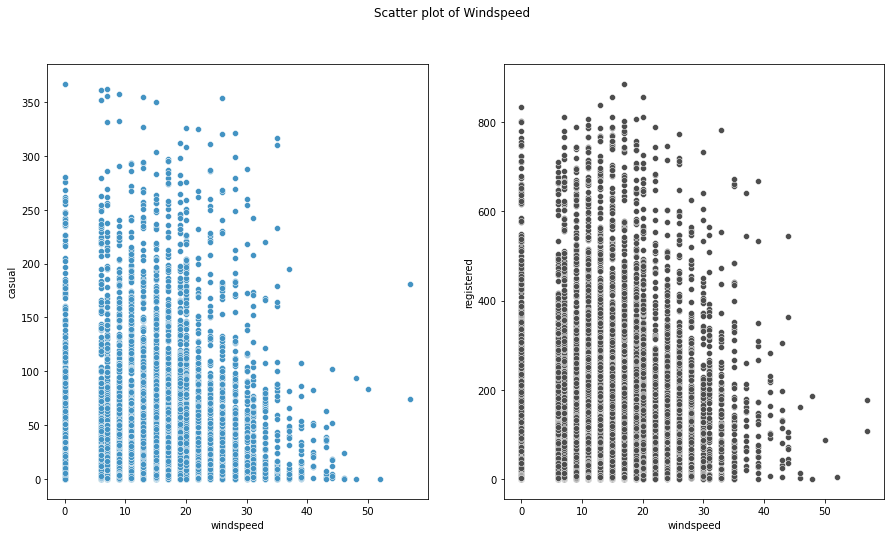

<Figure size 432x288 with 0 Axes>

In [11]:
# scatter plot of continuous features against target features

for feature in cont_cols[:-2]:
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    sns.scatterplot(data=eda_df, x=feature, y=targets[0], ax=axs[0], color=blue)
    sns.scatterplot(data=eda_df, x=feature, y=targets[1], ax=axs[1], color=ach)
    fig.suptitle(f'Scatter plot of {feature.title()}')
    plt.show()
plt.clf()

In [12]:
# first we change the binary* description to their actual representation
months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
weekdays = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
seasons = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
weather = {1:'clear', 2:'cloudy', 3:'light rain', 4:'snowy'}
eda_df['month'] = eda_df['month'].map(months)
eda_df['dayofweek'] = eda_df['dayofweek'].map(weekdays)
eda_df['season'] = eda_df['season'].map(seasons)
eda_df['weather'] = eda_df['weather'].map(weather)

for feature in cat_cols:
    distinct = eda_df[feature].unique()
    if len(distinct) == 2:
        print(f'Unique Features in {feature} = {distinct}')

Unique Features in year = [2011 2012]
Unique Features in holiday = [0 1]
Unique Features in workingday = [0 1]


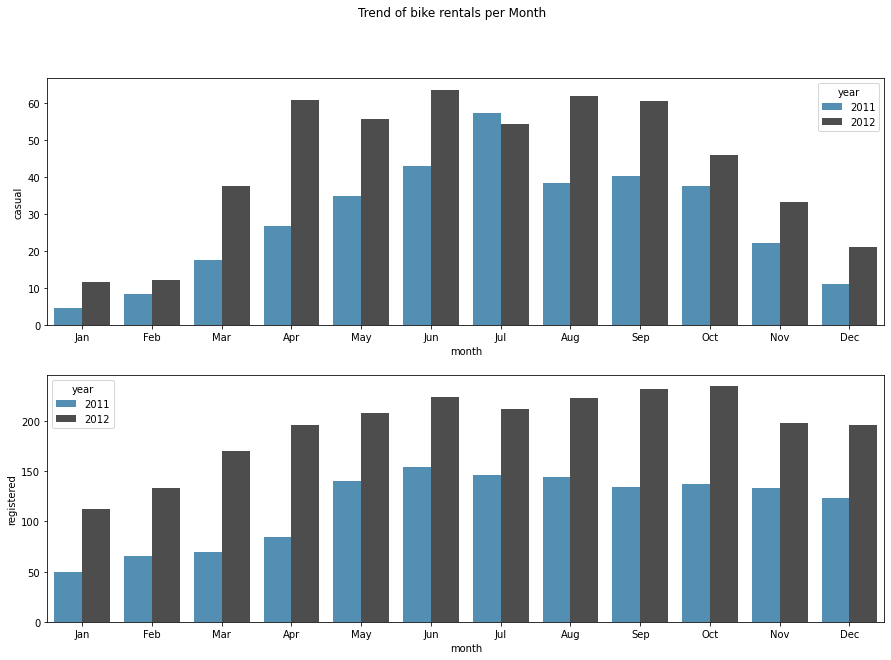

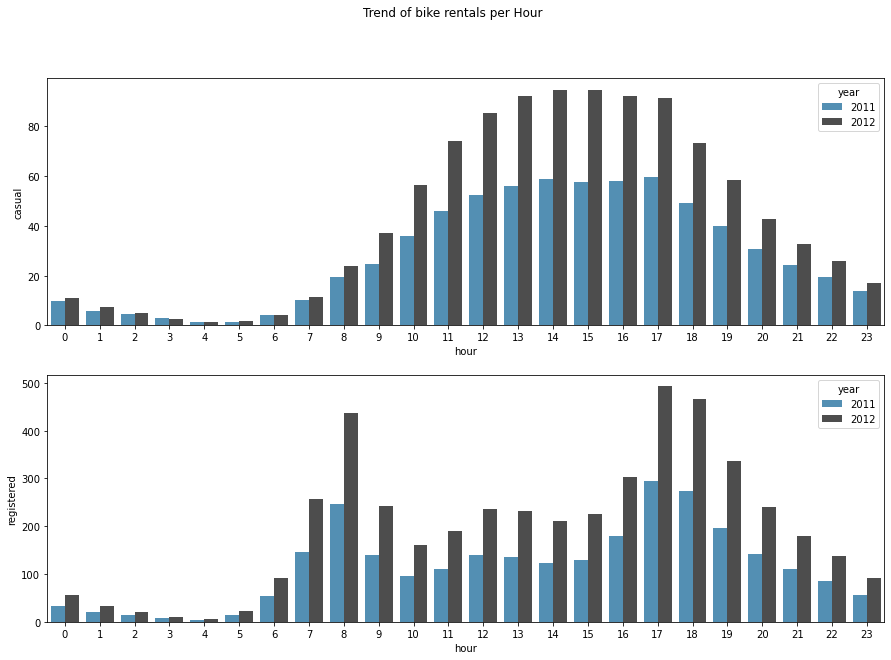

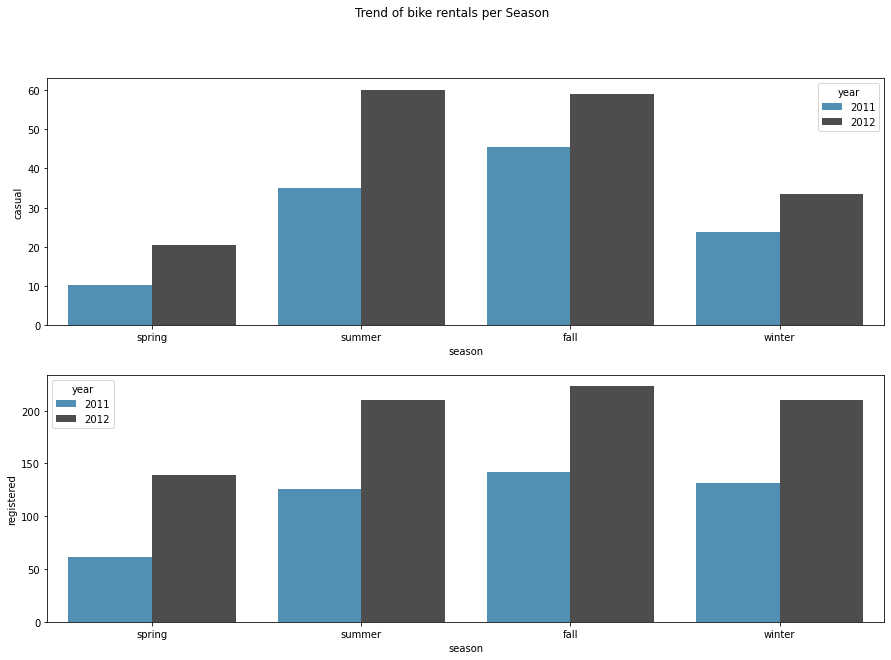

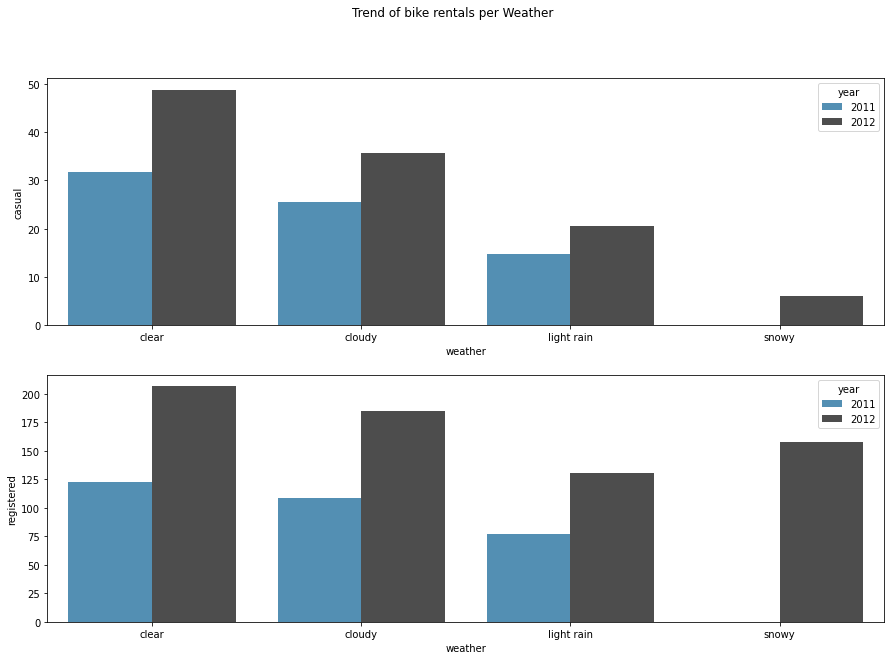

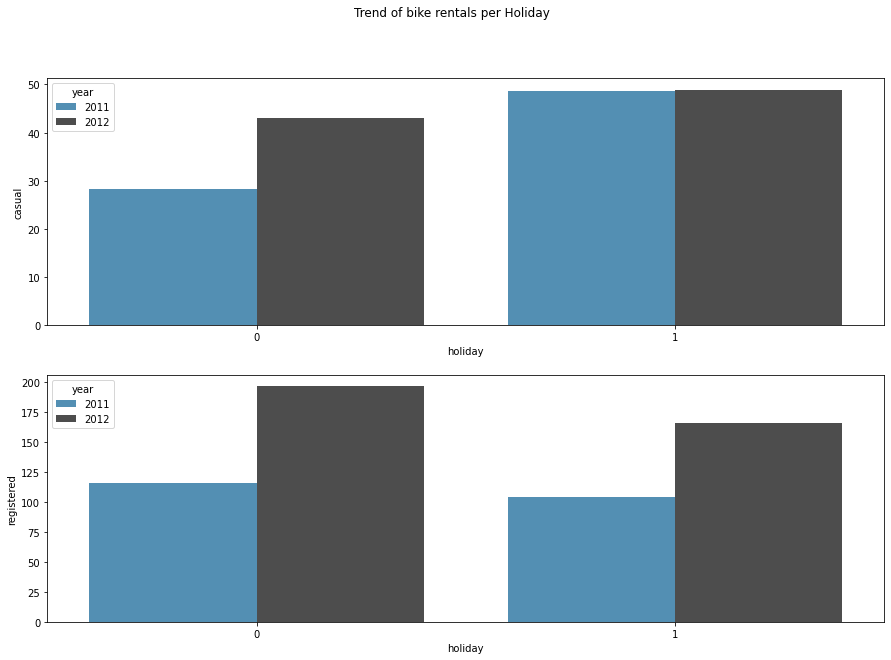

<Figure size 432x288 with 0 Axes>

In [13]:
# bar chart of categorical features
# exploring the trend of bike rental in both years (2011 and 2012)

features_of_interest = ['month', 'hour', 'season', 'weather', 'holiday']
for feature in features_of_interest:
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
    sns.barplot(data=eda_df, x=feature, y=targets[0], hue='year', palette=blue+ach, ax=axs[0], errorbar=None)
    sns.barplot(data=eda_df, x=feature, y=targets[1], hue='year', palette=blue+ach, ax=axs[1], errorbar=None)
    fig.suptitle(f'Trend of bike rentals per {feature.title()}')
    plt.show()
plt.clf()

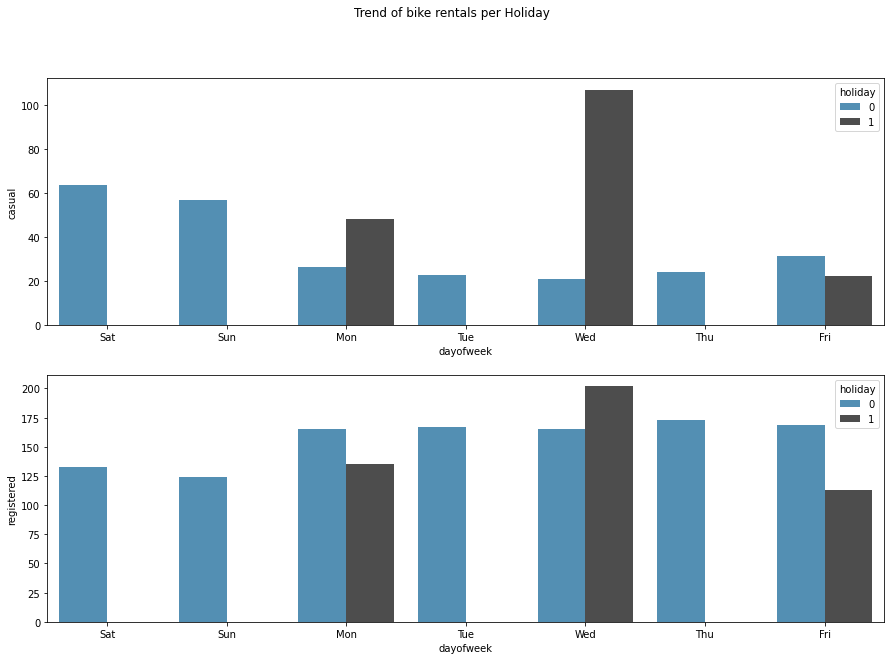

<Figure size 432x288 with 0 Axes>

In [14]:
# trend of bike sharing during the days of the week when its a holiday

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.barplot(data=eda_df, x='dayofweek', y=targets[0], hue='holiday', palette=blue+ach, ax=axs[0], errorbar=None)
sns.barplot(data=eda_df, x='dayofweek', y=targets[1], hue='holiday', palette=blue+ach, ax=axs[1], errorbar=None)
fig.suptitle(f'Trend of bike rentals per {feature.title()}')
plt.show()
plt.clf()

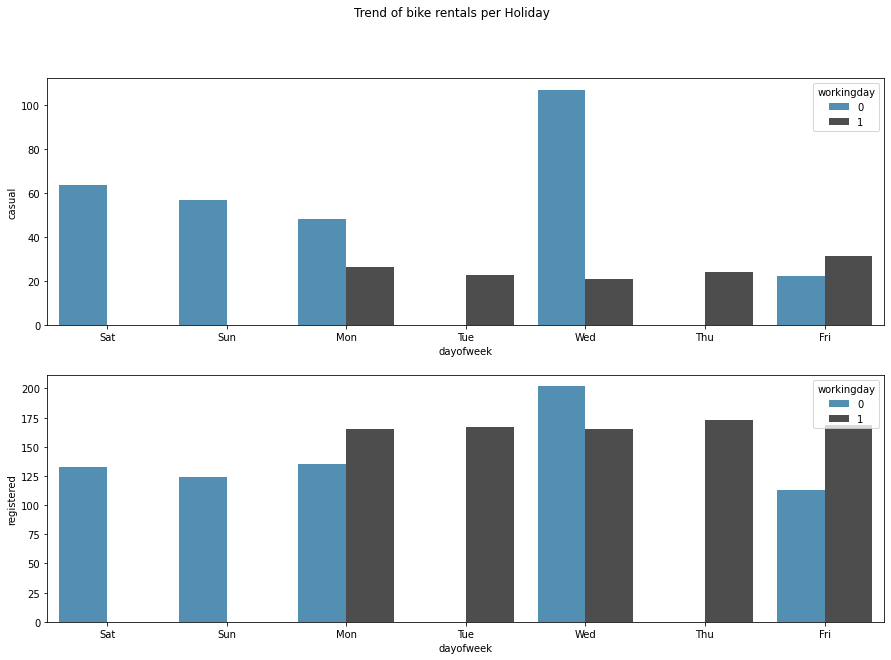

<Figure size 432x288 with 0 Axes>

In [15]:
# trend of bike sharing during the days of the week when its a working day

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.barplot(data=eda_df, x='dayofweek', y=targets[0], hue='workingday', palette=blue+ach, ax=axs[0], errorbar=None)
sns.barplot(data=eda_df, x='dayofweek', y=targets[1], hue='workingday', palette=blue+ach, ax=axs[1], errorbar=None)
fig.suptitle(f'Trend of bike rentals per {feature.title()}')
plt.show()
plt.clf()

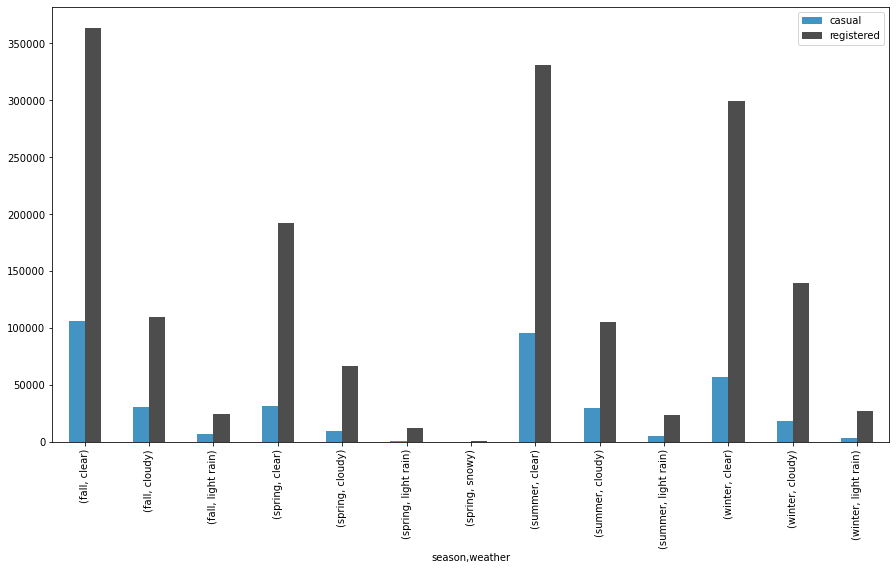

<Figure size 432x288 with 0 Axes>

In [16]:
# number of bike rentals based on the season and weather

group_season_weather = eda_df.groupby(['season','weather'])[['casual','registered']].sum()
group_season_weather.plot.bar(figsize=(15,8), color=blue+ach)
plt.legend()
plt.show()
plt.clf()

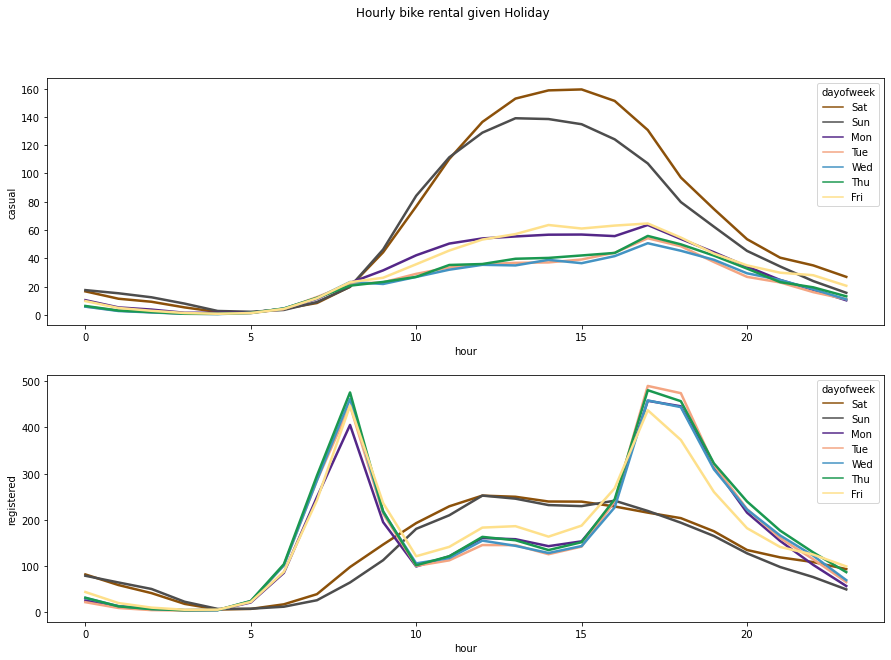

<Figure size 432x288 with 0 Axes>

In [17]:
# investigating the trend of rent during day of week and time by casual and registered bikers
palette = ['#8c510a','#4d4d4d','#542788','#f4a582','#4393c3','#1a9850','#fee08b']

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
sns.lineplot(data=eda_df, x='hour', y=targets[0], linewidth=2.5, palette=palette, hue='dayofweek', ax=axs[0], err_style=None)
sns.lineplot(data=eda_df, x='hour', y=targets[1], linewidth=2.5, palette=palette, hue='dayofweek', ax=axs[1], err_style=None)
fig.suptitle(f'Hourly bike rental given {feature.title()}')
plt.show()
plt.clf()

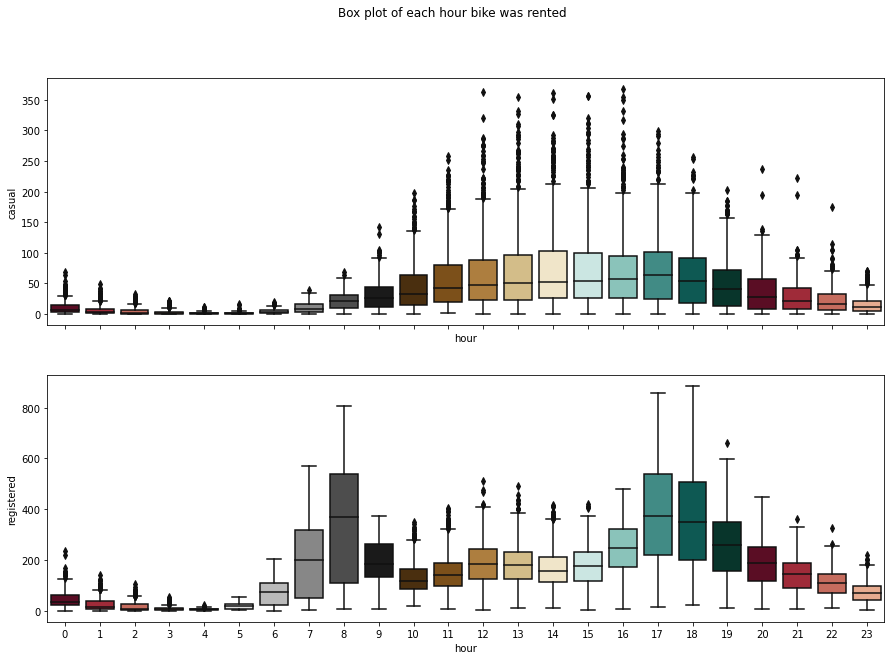

<Figure size 432x288 with 0 Axes>

In [18]:
# investigatin the variations of the hour the bike was rented with respect to the target features
hour = eda_df['hour']

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,10))
sns.boxplot(data=eda_df, x=hour, y=targets[0], ax=axs[0], palette=div2+div1)
sns.boxplot(data=eda_df, x=hour, y=targets[1], ax=axs[1], palette=div2+div1)
fig.suptitle('Box plot of each hour bike was rented')
plt.show()
plt.clf()

#### Data Qualitty Report
__Continuous Features__ <br>
```['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']```

In [19]:
# Description of continuous features
cont_description = ['Temperature in Celsius', 'Feels like temperature in Celsius',
                    'Relative humidity', 'Wind speed', 'Number of non-registered user rentals',
                    'Number of registed user rentals', 'Total number of rentals']

continuous_features_dqr = pd.DataFrame()

for idx, feature in enumerate(numcols):
    cont_dqr = pd.DataFrame()
    cont_dqr['Features'] = [feature]
    cont_dqr['Description'] = [cont_description[idx]]
    cont_dqr['Count'] = [eda_df[feature].shape[0]]
    cont_dqr['% of Missing'] = [eda_df[feature].isnull().sum() / eda_df[feature].shape[0]]
    cont_dqr['Card.'] = [eda_df[feature].nunique()]
    cont_dqr['Min #'] = [eda_df[feature].min()]
    cont_dqr['Q1'] = [eda_df[feature].describe()[4]]
    cont_dqr['Median'] = [eda_df[feature].median()]
    cont_dqr['Q3'] = [eda_df[feature].describe()[6]]
    cont_dqr['Max #'] = [eda_df[feature].max()]
    cont_dqr['Std. Dev.'] = [eda_df[feature].std()]
    continuous_features_dqr = pd.concat([continuous_features_dqr, cont_dqr],
                                         axis=0, ignore_index=True)
    
continuous_features_dqr

,Features,Description,Count,% of Missing,Card.,Min #,Q1,Median,Q3,Max #,Std. Dev.
0,temp,Temperature in Celsius,10886,0.0,49,0.82,13.9400,20.500,26.2400,41.0000,7.791590
1,atemp,Feels like temperature in Celsius,10886,0.0,60,0.76,16.6650,24.240,31.0600,45.4550,8.474601
2,humidity,Relative humidity,10886,0.0,89,0.00,47.0000,62.000,77.0000,100.0000,19.245033
3,windspeed,Wind speed,10886,0.0,28,0.00,7.0015,12.998,16.9979,56.9969,8.164537
4,casual,Number of non-registered user rentals,10886,0.0,309,0.00,4.0000,17.000,49.0000,367.0000,49.960477
5,registered,Number of registed user rentals,10886,0.0,731,0.00,36.0000,118.000,222.0000,886.0000,151.039033
6,count,Total number of rentals,10886,0.0,822,1.00,42.0000,145.000,284.0000,977.0000,181.144454


__Categorical Features__ <br>
```['year', 'month', 'day', 'dayofweek', 'hour', 'season', 'holiday', 'workingday', 'weather']```

In [20]:
# Description of categorical features
cat_description = ['Year of rental', 'Month of rental', 'Day of rental', 'Day of week',
                   'Hour of day', 'Current Season', 'Day is holiday or not', 
                    'Day is working day or not', 'Current weather']

categorical_features_dqr = pd.DataFrame()

for idx, feature in enumerate(cat_cols):
    cat_dqr = pd.DataFrame()
    cat_dqr['Features'] = [feature]
    cat_dqr['Description'] = [cat_description[idx]]
    cat_dqr['Count'] = [eda_df[feature].shape[0]]
    cat_dqr['% of Missing'] = [eda_df[feature].isnull().sum() / eda_df[feature].shape[0]]
    cat_dqr['Card.'] = [eda_df[feature].nunique()]
    cat_dqr['1st Mode'] = [eda_df[feature].mode(dropna=True)[0]]
    cat_dqr['1st Mode Freq.'] = [eda_df[eda_df[feature] == cat_dqr['1st Mode'][0]].shape[0]]
    cat_dqr['1st Mode %'] = np.around(cat_dqr['1st Mode Freq.'] / cat_dqr['Count'] * 100, 2)
    cat_dqr['2nd Mode'] = [eda_df[eda_df[feature] != cat_dqr['1st Mode'][0]][feature].mode(dropna=True)[0]]
    cat_dqr['2nd Mode Freq.'] = [eda_df[eda_df[feature] == cat_dqr['2nd Mode'][0]].shape[0]]
    cat_dqr['2nd Mode %'] = np.around(cat_dqr['2nd Mode Freq.'] / cat_dqr['Count'] * 100, 2)
    categorical_features_dqr = pd.concat([categorical_features_dqr, cat_dqr],
                                         axis=0, ignore_index=True)
    
categorical_features_dqr

,Features,Description,Count,% of Missing,Card.,1st Mode,1st Mode Freq.,1st Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
0,year,Year of rental,10886,0.0,2,2012,5464,50.19,2011,5422,49.81
1,month,Month of rental,10886,0.0,12,Aug,912,8.38,Dec,912,8.38
2,day,Day of rental,10886,0.0,19,1,575,5.28,5,575,5.28
3,dayofweek,Day of week,10886,0.0,7,Sat,1584,14.55,Sun,1579,14.50
4,hour,Hour of day,10886,0.0,24,12,456,4.19,13,456,4.19
5,season,Current Season,10886,0.0,4,winter,2734,25.11,fall,2733,25.11
6,holiday,Day is holiday or not,10886,0.0,2,0,10575,97.14,1,311,2.86
7,workingday,Day is working day or not,10886,0.0,2,1,7412,68.09,0,3474,31.91
8,weather,Current weather,10886,0.0,4,clear,7192,66.07,cloudy,2834,26.03


### Dealing with Missing Values and Outliers

__Missing Values__

In [21]:
# checking for missing values in the eda dataset
eda_df.isnull().any()

year          False
month         False
day           False
dayofweek     False
hour          False
season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual        False
registered    False
count         False
dtype: bool

__Outliers__

In [22]:
# investigating and removing potential outliers in the dataset usig the k%

def remove_outlier(df):
    """ Function Name: remove outliers
            This function takes in a dataframe and removes
            top and bottom k% outliers in count and also
            take out dangerous windspeed (>29mph)
    """
    # At 30mph or, the wind makes cycling quite difficult,
    # even for the more experienced cyclist.
    windtresh  = 29
    tresh = df['windspeed'] > windtresh
    df = df.drop(index=df[tresh].index)

    k = 2
    lower = df['count'] < df['count'].quantile(k/100)
    upper = df['count'] > df['count'].quantile(1-k/100)
    df = df.drop(index=df[lower].index)
    df = df.drop(index=df[upper].index)
        
    return df

outlier_removed = remove_outlier(eda_df)
print(eda_df.shape, outlier_removed.shape)

(10886, 16) (10155, 16)


In [23]:
""" UNCOMMENT ME """

# # visualizing the change in distribution for the continuous columns
# for feature in numcols:
#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
#     sns.histplot(data=eda_df, x=feature, bins=20, kde=True, ax=axs[0])
#     sns.histplot(data=outlier_removed, x=feature, bins=20, kde=True, ax=axs[1])
#     plt.show()
# plt.clf()

# # visualizing the change in variation for the categorical columns
# for feature in cat_cols:
#     fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
#     sns.boxplot(data=eda_df, x=feature, y=targets[2], ax=axs[0], palette=div2+div1)
#     sns.boxplot(data=outlier_removed, x=feature, y=targets[2], ax=axs[1], palette=div2+div1)
#     plt.show()
# plt.clf()

' UNCOMMENT ME '

### Normalizing Continuours Features

In [24]:
def normalize(df, cols):
    """ Function Name: Normalize
            This function takes a dataframe and specified numerical
            columns and transforms them between [0, 1]
    """
    for feature in cols:
        minval, maxval = df[feature].min(), df[feature].max()
        df[feature] = ( df[feature] - minval ) / ( maxval - minval )

    return df

eda_df = normalize(outlier_removed, cont_cols)

### Feature Selection and Transformation

__Selection__ <br>
`keep: [temp, humidity, registered, year, hour, season, weather]`

In [25]:
# * note to self * TRY USING THE WRAPPER METHOD 

remove = ['month', 'day', 'dayofweek', 'holiday', 'workingday', 'atemp', 'windspeed', 'casual']
eda_df.drop(columns=remove, inplace=True)

__Transformation__

In [26]:
# creating dummies for categorical features

dummy = ['year', 'hour', 'season', 'weather']
eda_df[['year', 'hour']] = eda_df[['year', 'hour']].astype('object')
eda_df = pd.get_dummies(eda_df, columns=dummy, drop_first=True)
eda_df

,temp,humidity,registered,count,year_2012,hour_1,hour_2,hour_3,hour_4,hour_5,...,hour_20,hour_21,hour_22,hour_23,season_spring,season_summer,season_winter,weather_cloudy,weather_light rain,weather_snowy
0,0.224490,0.81,0.019461,16,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.204082,0.80,0.047904,40,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.204082,0.80,0.040419,32,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.224490,0.75,0.014970,13,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0.204082,0.80,0.000000,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0.367347,0.50,0.492515,336,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10882,0.346939,0.57,0.345808,241,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
10883,0.326531,0.61,0.245509,168,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
10884,0.326531,0.61,0.175150,129,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [27]:
# * note to self: *
# binning the target feature into 4 bins (1. using the iqr | 2. using equal width binning)
# 1: few; 2: okay; 3: enough; 4: a_lot

eda_iqr = eda_df.copy()
eda_bin = eda_df.copy()

def bin_target(df, target='count'):
    temp = df[target].to_numpy()
    new = []
    lower, upper = np.min(temp), np.max(temp)
    inc = (upper - lower) / 4

    for val in temp:
        if val <= inc :
            new.append(1)
        elif val <= 2*inc :
            new.append(2)
        elif val <= 3*inc :
            new.append(3)
        else:
            new.append(4)
    df[target] = new

    return df

def iqr_target(df, target='count'):
    temp = df[target].to_numpy()
    new = []
    lower, med, upper = df[target].quantile([.25, .5, .75])

    for val in temp:
        if val <= lower :
            new.append(1)
        elif val <= med :
            new.append(2)
        elif val <= upper :
            new.append(3)
        else:
            new.append(4)
    df[target] = new

    return df

eda_bin = bin_target(eda_bin, 'count')
eda_iqr = iqr_target(eda_iqr, 'count')

### MODEL SELECTION AND EVALUATION
Data sets used: `eda_df, eda_bin, eda_iqr`

In [28]:
# inporting useful librabries

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_log_error

In [29]:
### group by year and season and check the mean for each feature